<a href="https://colab.research.google.com/github/Anjasfedo/pytorch/blob/computer_vision/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA).
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

2.3.0+cu121


## 1. What are 3 areas in industry where computer vision is currently being used?

In [ ]:
1. Image classification
2. Image segmentation
3. Object detection

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

In [ ]:
Overfitting is when a model of machine learning learn too well on train data and perform poorly on test data.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each.
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

In [ ]:
Way to prefent overfitting
1. Train with more data
2. Early stopping the train loops
3. Hyperparameter tuning

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

In [ ]:
Done

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [17]:
from torchvision import datasets
from torchvision import transforms

train_datasets = datasets.MNIST(root="data",
                              train=True,
                              download=True,
                              transform=transforms.ToTensor())

test_datasets = datasets.MNIST(root="data",
                             train=False,
                             download=True,
                             transform=transforms.ToTensor())

print(len(train_datasets), len(test_datasets))

60000 10000


## 6. Visualize at least 5 different samples of the MNIST training dataset.

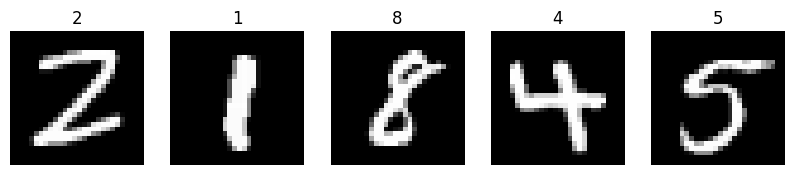

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
cols = 5
for i in range(1, cols + 1):
  random_i = torch.randint(len(train_datasets), size=(1,)).item()

  img, label = train_datasets[random_i]

  fig.add_subplot(1, cols, i)
  plt.title(label)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.axis(False)

plt.show()

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [25]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_datasets,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(test_datasets,
                             batch_size=32,
                             shuffle=False)

class_names = train_datasets.classes
print(class_names, len(class_names))

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'] 10


## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [27]:
from torch import nn

class MNISTModel0(nn.Module):
  def __init__(self,
               input_shape,
               hidden_units,
               output_shape):

    super().__init__()
    self.conv_block_1 = nn.Sequential(
    nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

model_0 = MNISTModel0(input_shape=1,
                      hidden_units=10,
                      output_shape=len(class_names)).to(device)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [41]:

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device):
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  for batch, (X, y) in enumerate(data_loader):
    # Put data into target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss & acc (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples")

  # Scale loss
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

  return train_loss, train_acc

In [42]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device=device):
  test_loss, test_acc = 0, 0

  # Put model into evaluation mode
  model.eval()

  # Turn on inference mode
  with torch.inference_mode():
    for X, y in data_loader:
      # Put data into target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate test loss & acc (per batch)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                         y_pred=test_pred.argmax(dim=1))

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

    return test_loss, test_acc

In [48]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time


In [43]:
import requests
from pathlib import Path

# Download helper function
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

helper_functions.py already exists, skipping download...


In [46]:
# Setup loss function & optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [49]:
from tqdm.auto import tqdm
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_0 = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_loss, train_acc = train_step(model=model_0,
                                     data_loader=train_dataloader,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     accuracy_fn=accuracy_fn,
                                     device=device)
  test_loss, test_acc = test_step(model=model_0,
                                  data_loader=test_dataloader,
                                  loss_fn=loss_fn,
                                  accuracy_fn=accuracy_fn,
                                  device=device)

train_time_end_model_0 = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_model_0,
                                            end=train_time_end_model_0,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.04019 | Train acc: 98.73%
Test loss: 0.04417 | Test acc: 98.62%

Epoch: 1
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.03613 | Train acc: 98.89%
Test loss: 0.04666 | Test acc: 98.55%

Epoch: 2
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.03264 | Train acc: 98.96%
Test loss: 0.04196 | Test acc: 98.66%

Epoch: 3
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.03046 | Train acc: 99.02%
Test loss: 0.03939 | Test acc: 98.72%

Epoch: 4
---------
Looke

## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [50]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device=device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_probs off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [51]:
import random

random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_datasets), k=5):
  test_samples.append(sample)
  test_labels.append(label)

In [52]:
# Make predictions
pred_probs = make_predictions(model=model_0,
                              data=test_samples)

# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 1, 2, 4, 6])

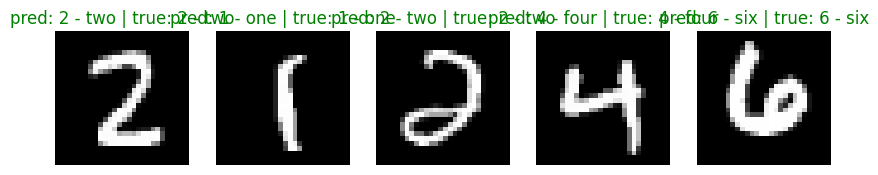

In [53]:
# Plot predictions
plt.figure(figsize=(10, 10))
nrows = 1
ncols = 5

for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form)
  pred_label = class_names[pred_classes[i]]
  true_label = class_names[test_labels[i]]

  # Create title for the plot
  title_color = "g" if pred_label == true_label else "r"
  plt.title(f"pred: {pred_label} | true: {true_label}",
            color=title_color)

  plt.axis(False)

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [55]:
y_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader,
                   desc="Making predictions..."):

    X, y = X.to(device), y.to(device)

    # Forward pass
    y_logit = model_0(X)

    # Turn prediction from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
print(y_pred_tensor)
print(f"Shape of y_pred_tensor: {y_pred_tensor.shape}")

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([7, 2, 1,  ..., 4, 5, 6])
Shape of y_pred_tensor: torch.Size([10000])


In [56]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlextend version shoud be 0.19.0 or higher")
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 36.4 MB/s eta 0:00:00


Exception ignored in: <function tqdm.__del__ at 0x795382382dd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.10/dist-packages/tqdm/notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


mlxtend version: 0.23.1


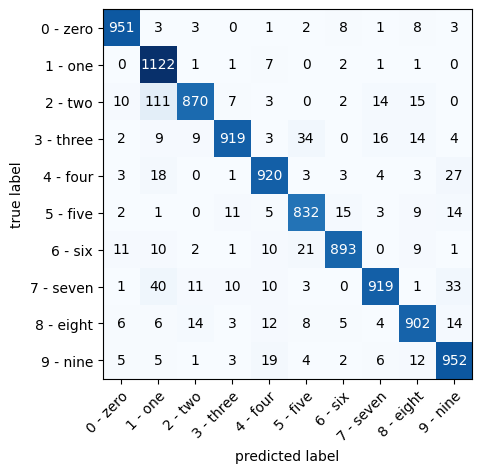

In [57]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names),
                          task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_datasets.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names)

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [62]:
torch.manual_seed(42)
random_tensor = torch.rand(size=(1, 3, 64, 64))
print(random_tensor.shape)

# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

# Pass data through convolutional layer
conv_output = conv_layer(random_tensor)
print(conv_output.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 10, 62, 62])


## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?